In [1]:
from matplotlib import *
import matplotlib.pyplot as plt
%pylab inline
from pylab import rcParams
rcParams['figure.figsize'] = 16, 16

from skimage import io
from scipy import misc, ndimage
import numpy as np
import copy
import dtcwt
from dtcwt import plotting, Transform2d, sampling, utils
from dtcwt.features import slp2
img = io.imread('/media/stewart/LocalData/Downloads/Lenna.png', 'gray')
img = dtcwt.utils.drawedge(0, [512.5, 512.5], 16, 1024) \
      * dtcwt.utils.drawedge(90, [512.5, 512.5], 16, 1024) + np.random.rand(1024,1024)*0.05

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.4/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['rcdefaults', 'f', 'rc_context', 'colors', 'test', 'rc', 'cycler']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
transform = dtcwt.Transform2d(biort='near_sym_b_bp', qshift='qshift_b_bp')
max_level = 5
dtcwtpyramid = transform.forward(img, nlevels=max_level)
w = copy.deepcopy(dtcwtpyramid) # This is where we will attempt to inter recovered DTCWT coefficients
slp2pyramid = slp2(img, nlevels=max_level, full=True, firstlevel=0, verbose=True)

In [3]:
sampleLocs = slp2pyramid.init()

SLP2 sampling locations calculated.



In [4]:
imgslp2, diffs = slp2pyramid.transform(img, sampleLocs)

SLP2 coefficients computed.


In [5]:
imgslp2[2].shape

(128, 128, 6)

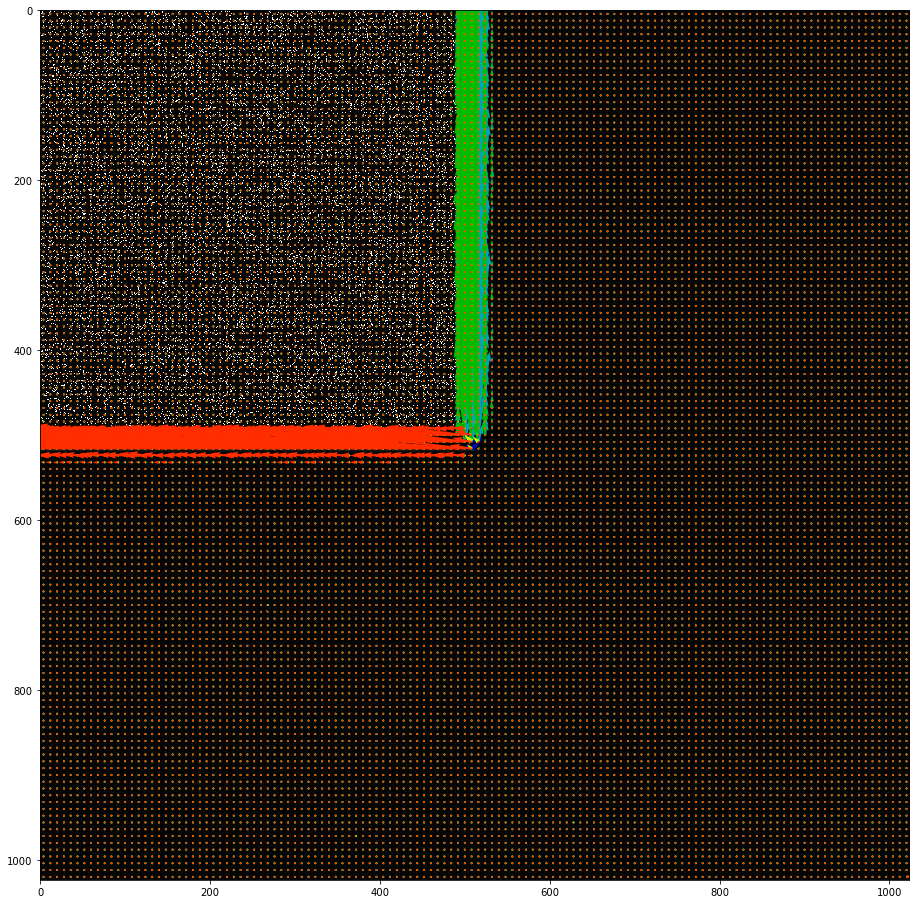

In [6]:
dtcwt.plotting.overlay_quiver(np.uint8(img*255), imgslp2[2], 3, 0.5)

0.0223746680176


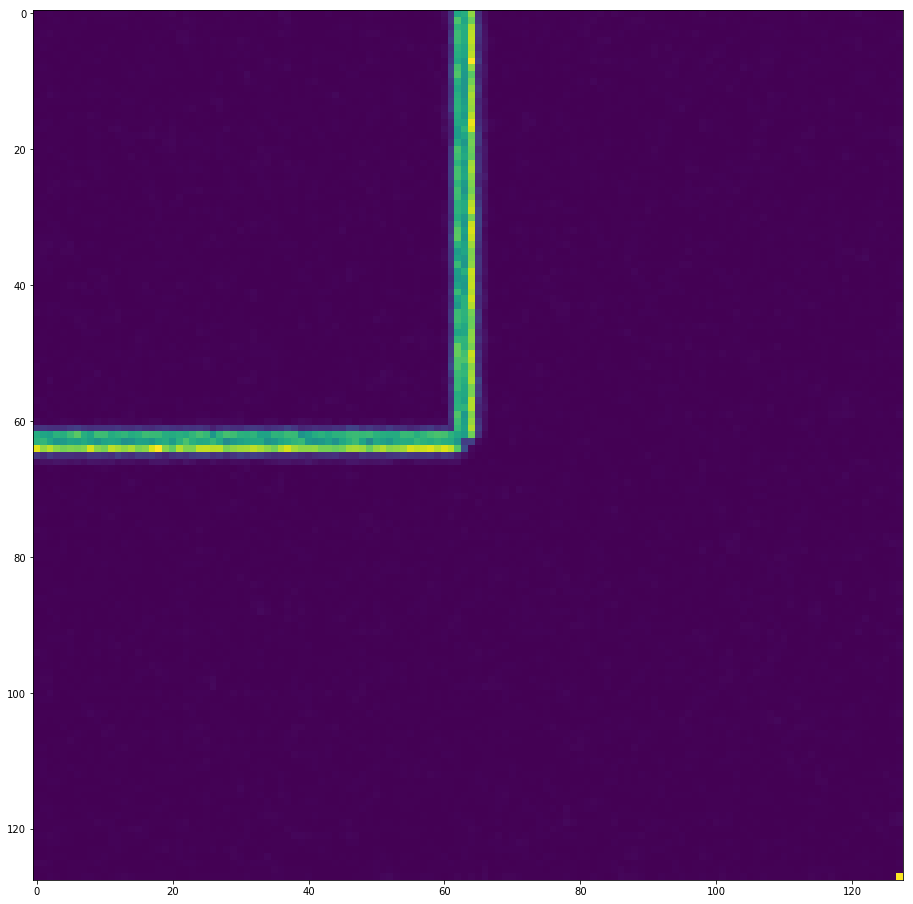

In [7]:
print(np.max(np.abs(imgslp2[2].flatten())))
imshow(np.max(np.abs(imgslp2[2]), axis=-1))

# Subband 1

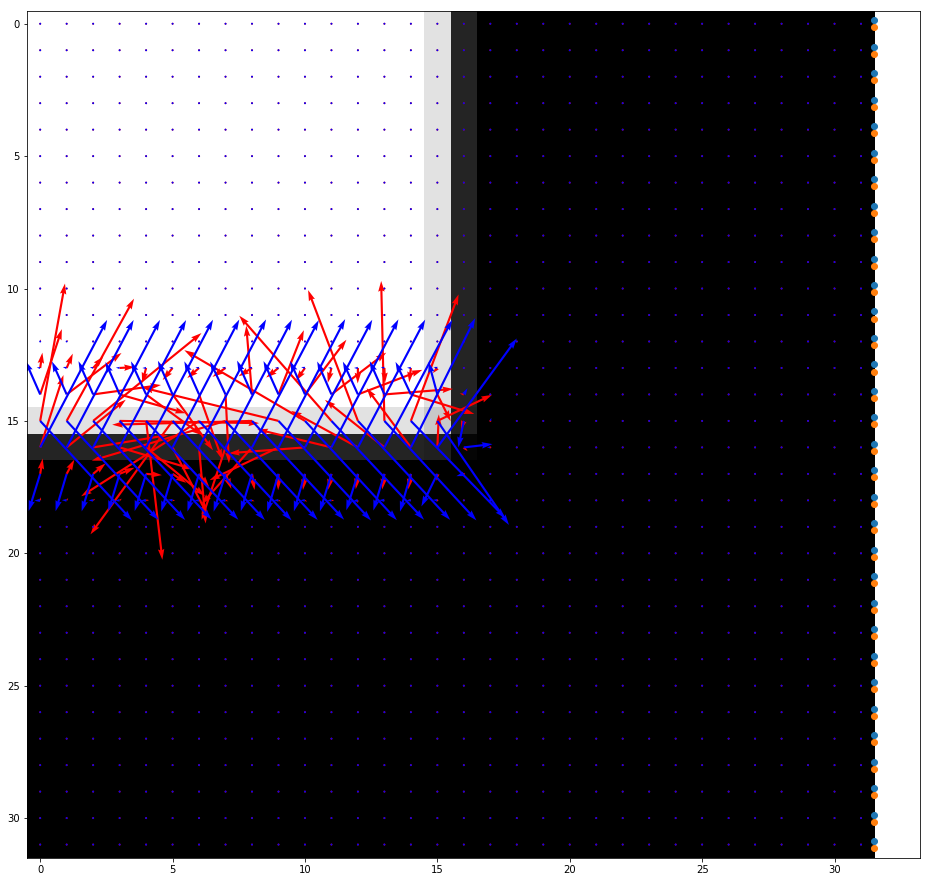

In [8]:
for level in range(0,max_level):
    U, V = np.meshgrid(range(0, imgslp2[level].shape[1]), range(0, imgslp2[level].shape[0]))
    l1 = (np.random.rand(imgslp2[level].shape[0],1)*(np.random.rand(imgslp2[level].shape[0],1)-0.5) + 1j*2*(np.random.rand(imgslp2[level].shape[0],1)-0.5))
    l1[:] = 1 + 1j
    #l1 = (dtcwt.sampling.sample_highpass(
    #            np.tile(dtcwtpyramid.highpasses[level][:,0,0].reshape(dtcwtpyramid.highpasses[level][:,0,0].shape[0], 1, 1), [1,2,6]), 
    #            U[:,[0,0]]-0.5, V[:,[0,0]] + np.sin(15*np.pi/180), method='bilinear', sbs=[0])[:,0,:])
    #l1 = dtcwtpyramid.highpasses[level][:,0,0]
    for c in range(0, imgslp2[level].shape[1]):

        # Normalise the magnitude of the SLP2 value to stop it running away and becoming huge
        wdelta = (imgslp2[level][:,c,0]/np.abs(imgslp2[level][:,c,0])*np.exp(-1j*np.pi/12))**(slp2pyramid.rotratio[level,0]*1.035) # This should now contain the phase difference over one full pixel
        #print(np.angle(diffs[level][0,c,0]**0.5), np.angle(np.conj(wdelta[0]**0.5))) # This shows it does
        w.highpasses[level][:,c,0] = np.sqrt(np.abs(imgslp2[level][:,c,0]))*np.exp(1j*np.angle(np.multiply(l1.flatten(), wdelta**0.5)))
        u1 = np.multiply(l1.flatten(), wdelta).T
        if np.any(np.isnan(l1.flatten())):
            print(c)
            raise ValueError('Nans detected')
        #l1 = (dtcwt.sampling.sample_highpass(
        #        np.tile(u1.reshape(len(u1), 1, 1), [1,2,6]), 
        #        U[:,[0,0]]+0.5, V[:,[0,0]] + np.sin(15*np.pi/180), method='bilinear', sbs=[0]))[:,0,0]
        omega_x = -1*np.pi/2.15 * (U[:,c]+0.5*1.035*np.cos(15*np.pi/180))
        omega_y = -3*np.pi/2.15 * (V[:,c]-0.5*1.035*np.sin(15*np.pi/180))
        u1lowpass = u1.flatten() * np.exp(-1j*(omega_x + omega_y))
        omega_x = -1*np.pi/2.15 * (U[:,c]+0.5*1.035*np.cos(15*np.pi/180))
        omega_y = -3*np.pi/2.15 * (V[:,c]+0.5*1.035*np.sin(15*np.pi/180))
        
        l1 = np.interp(V[:,c] + 0.5*1.035*np.sin(15*np.pi/180), \
                       V[:,c] - 0.5*1.035*np.sin(15*np.pi/180), \
                       u1lowpass) * np.exp(1j*(omega_x + omega_y))

#print((U[:,c]+1/1.035*np.cos(15*np.pi/180), (V[:,c]-0.5/1.035*np.sin(15*np.pi/180))))

imshow(misc.imresize(img, 2**-(level+1)), cmap='gray')
#xlim([-1,10])
#ylim([10,-1])
quiver(U, V, np.real(w.highpasses[level][:,:,0]), np.imag(w.highpasses[level][:,:,0]), color='r', scale=20)
quiver(U, V, np.real(dtcwtpyramid.highpasses[level][:,:,0]), np.imag(dtcwtpyramid.highpasses[level][:,:,0]), color='b', scale=20)
scatter(U[:,c]+0.5*1.035*np.cos(15*np.pi/180), V[:,c] - 0.5*1.035*np.sin(15*np.pi/180))
scatter(U[:,c]+0.5*1.035*np.cos(15*np.pi/180), V[:,c] + 0.5*1.035*np.sin(15*np.pi/180))

[-0.58094325 -0.54829626 -0.48423699 -0.42692528 -0.40165488 -0.39658479
 -0.39877734 -0.4068392  -0.40343274 -0.38367465  2.80039249  2.85355723
 -0.21799149 -0.21481363 -0.47049857 -1.49717938  0.20844999  0.75306383
 -1.32347725  1.11248123  1.48583497 -1.59214745 -1.93430854 -0.64206044
 -0.68281365  0.69750422  1.84602094  0.62982557  0.47954313  0.52301993
 -0.38953424 -1.27577348]


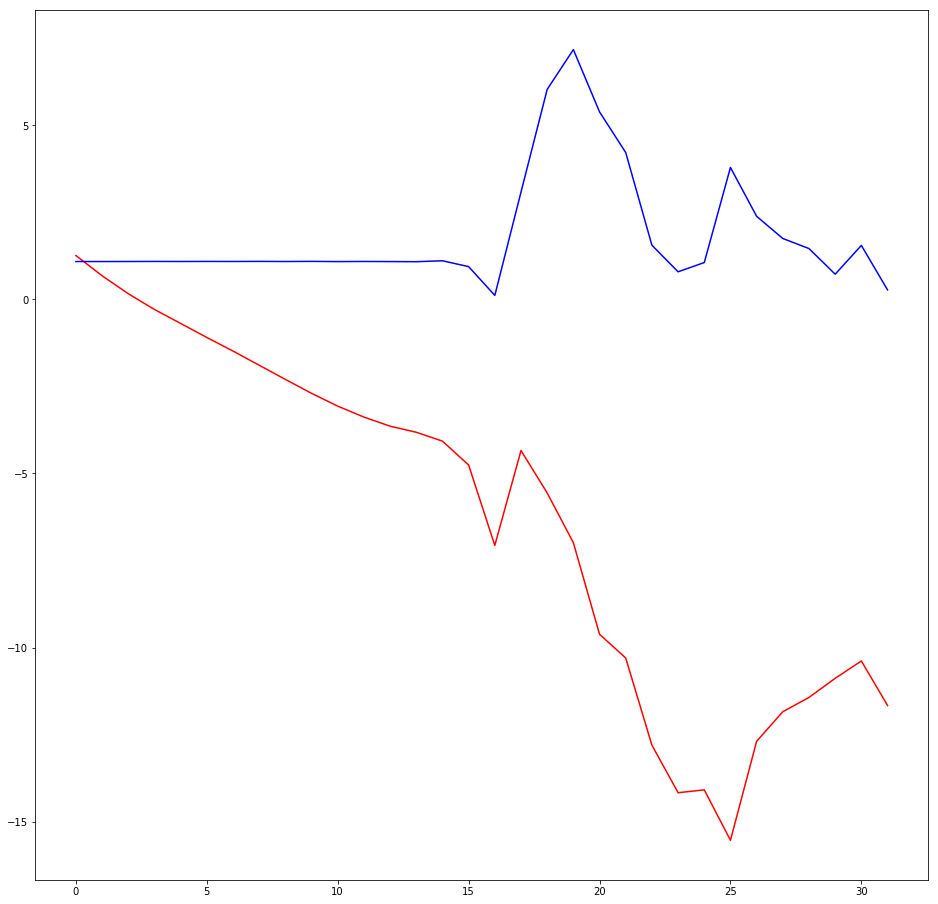

In [9]:
plot(np.unwrap(np.angle(w.highpasses[level][int(imgslp2[level].shape[0]/2),:,0])), color='r')
plot(np.unwrap(np.angle(dtcwtpyramid.highpasses[level][int(imgslp2[level].shape[0]/2),:,0])), color='b')
#ylim([-3.14,3.14])
print(np.gradient(np.angle(w.highpasses[level][int(imgslp2[level].shape[0]/2),:,0])))

# Subband 6

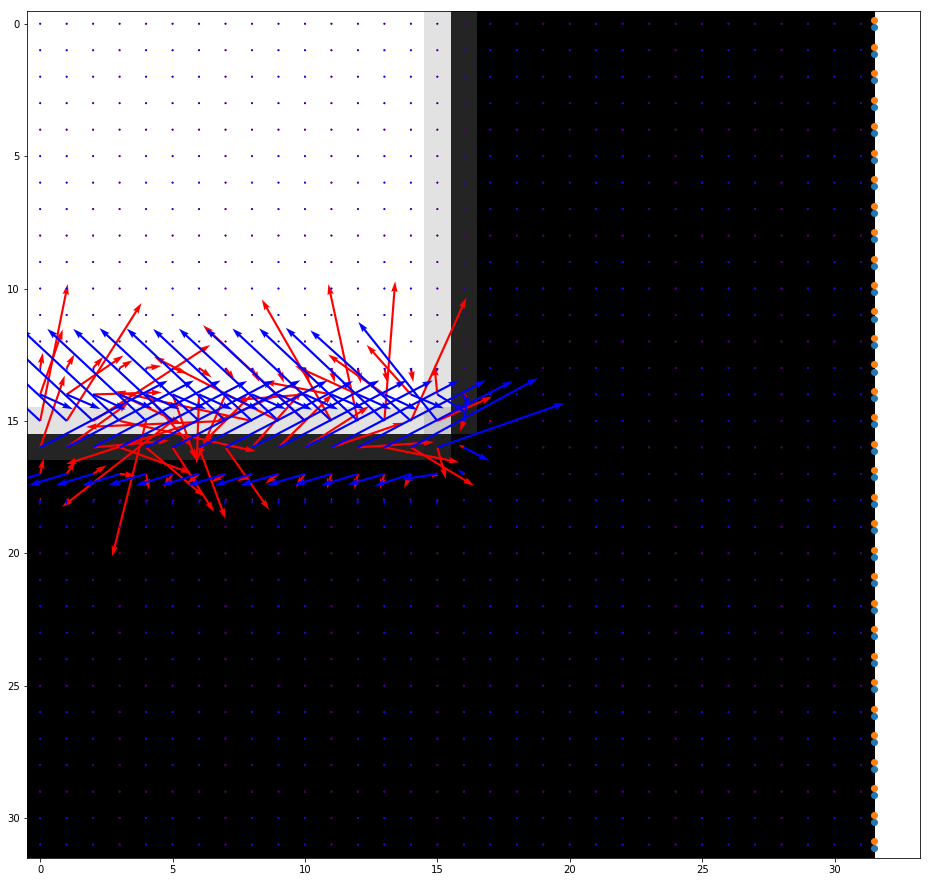

In [10]:
for level in range(0,max_level):
    U, V = np.meshgrid(range(0, imgslp2[level].shape[1]), range(0, imgslp2[level].shape[0]))
    u6 = (np.random.rand(imgslp2[level].shape[0],1)*(np.random.rand(imgslp2[level].shape[0],1)-0.5) + 1j*2*(np.random.rand(imgslp2[level].shape[0],1)-0.5))
    u6[:] = 1 + 1j
    #u6 = (dtcwt.sampling.sample_highpass(
    #            np.tile(dtcwtpyramid.highpasses[level][:,0,0].reshape(dtcwtpyramid.highpasses[level][:,0,0].shape[0], 1, 1), [1,2,6]), 
    #            U[:,[0,0]]+0.5, V[:,[0,0]] + np.sin(15*np.pi/180), method='bilinear', sbs=[0])[:,0,:])
    # u6 = dtcwtpyramid.highpasses[level][:,0,0]
    for c in range(0, imgslp2[level].shape[1]):

        # Normalise the magnitude of the SLP2 value to stop it running away and becoming huge
        wdelta = (imgslp2[level][:,c,5]/np.abs(imgslp2[level][:,c,5]) 
                  *np.exp(-1j*11*np.pi/12))**(-slp2pyramid.rotratio[level,5]) # This should now contain the phase difference over one full pixel
        #print(np.angle(diffs[level][0,c,5]**0.5), np.angle(np.conj(wdelta[0])**0.5)) # This shows it does
        w.highpasses[level][:,c,5] = np.sqrt(np.abs(imgslp2[level][:,c,5]))*np.exp(1j*np.angle(np.multiply(u6.flatten(), wdelta**0.5)))
        l6 = np.multiply(u6.flatten(), wdelta).T
        if np.any(np.isnan(l6.flatten())):
            print(c)
            raise ValueError('Nans detected')
        omega_x = -1*np.pi/2.15 * (U[:,c]+0.5*1.035*np.cos(15*np.pi/180))
        omega_y =  3*np.pi/2.15 * (V[:,c]+0.5*1.035*np.sin(15*np.pi/180))
        l6lowpass = l6.flatten() * np.exp(-1j*(omega_x + omega_y))
        omega_x = -1*np.pi/2.15 * (U[:,c]+0.5*1.035*np.cos(15*np.pi/180))
        omega_y =  3*np.pi/2.15 * (V[:,c]-0.5*1.035*np.sin(15*np.pi/180))
        u6 = np.interp(V[:,c] - 0.5*1.035*np.sin(15*np.pi/180), \
                       V[:,c] + 0.5*1.035*np.sin(15*np.pi/180), \
                       l6lowpass) * np.exp(1j*(omega_x + omega_y))


imshow(misc.imresize(img, 2**-(level+1)), cmap='gray')
#xlim([-1,10])
#ylim([10,-1])
quiver(U, V, np.real(w.highpasses[level][:,:,5]), np.imag(w.highpasses[level][:,:,5]), color='r', scale=20)
quiver(U, V, np.real(dtcwtpyramid.highpasses[level][:,:,5]), np.imag(dtcwtpyramid.highpasses[level][:,:,5]), color='b', scale=20)
scatter(U[:,c]+0.5*1.035*np.cos(15*np.pi/180), V[:,c] + 0.5*1.035*np.sin(15*np.pi/180))
scatter(U[:,c]+0.5*1.035*np.cos(15*np.pi/180), V[:,c] - 0.5*1.035*np.sin(15*np.pi/180))

[-0.6185695  -0.57586165 -0.48438271 -0.39589915 -0.32710398 -0.2577489
  0.01950597  1.0305821   0.86960348 -0.13692799 -0.22429038 -0.25084799
 -0.26281127 -0.30693903 -0.55472402  1.60316563  0.40538871 -2.5831666
  1.60247868  2.44234028 -0.30910674 -0.75018026 -1.03144265 -0.50833078
 -0.99149426  0.87139995  1.04876828 -1.71975067  0.73955583  1.25208747
 -0.97907856 -1.00468162]


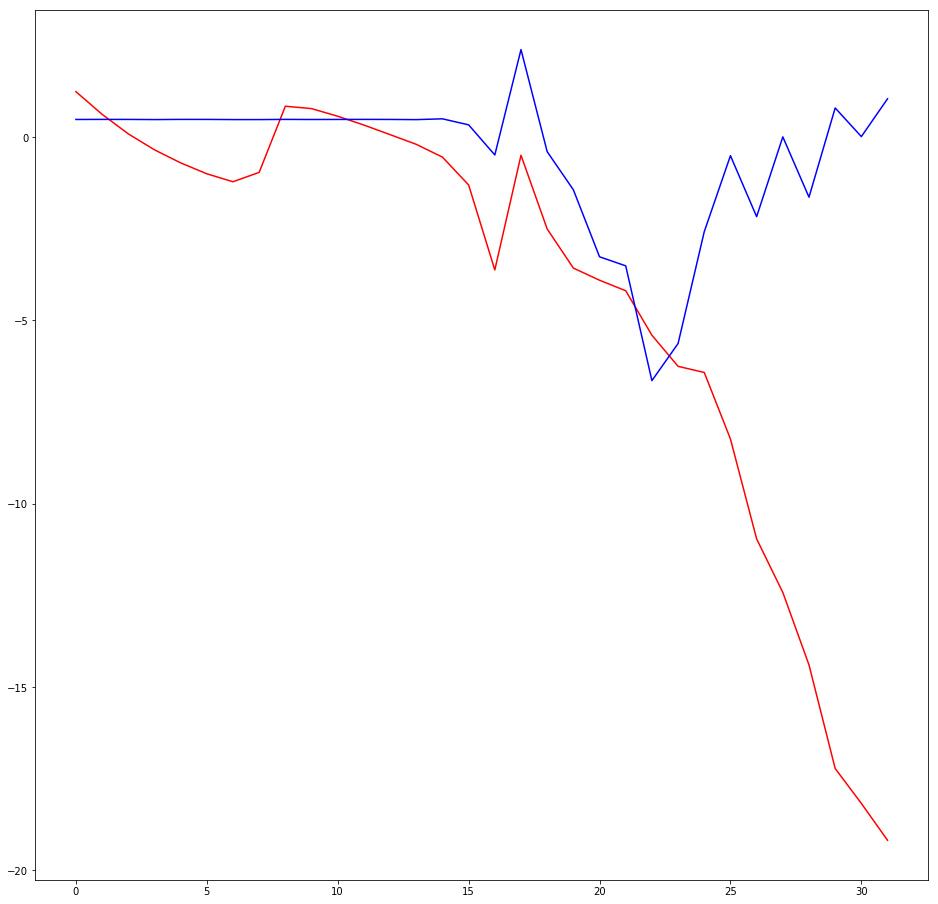

In [18]:
plot(np.unwrap(np.angle(w.highpasses[level][int(imgslp2[level].shape[0]/2),:,5])), color='r')
plot(np.unwrap(np.angle(dtcwtpyramid.highpasses[level][int(imgslp2[level].shape[0]/2),:,5])), color='b')
#ylim([-3.14,3.14])
print(np.gradient(np.angle(w.highpasses[level][int(imgslp2[level].shape[0]/2),:,5])))

# Subband 3

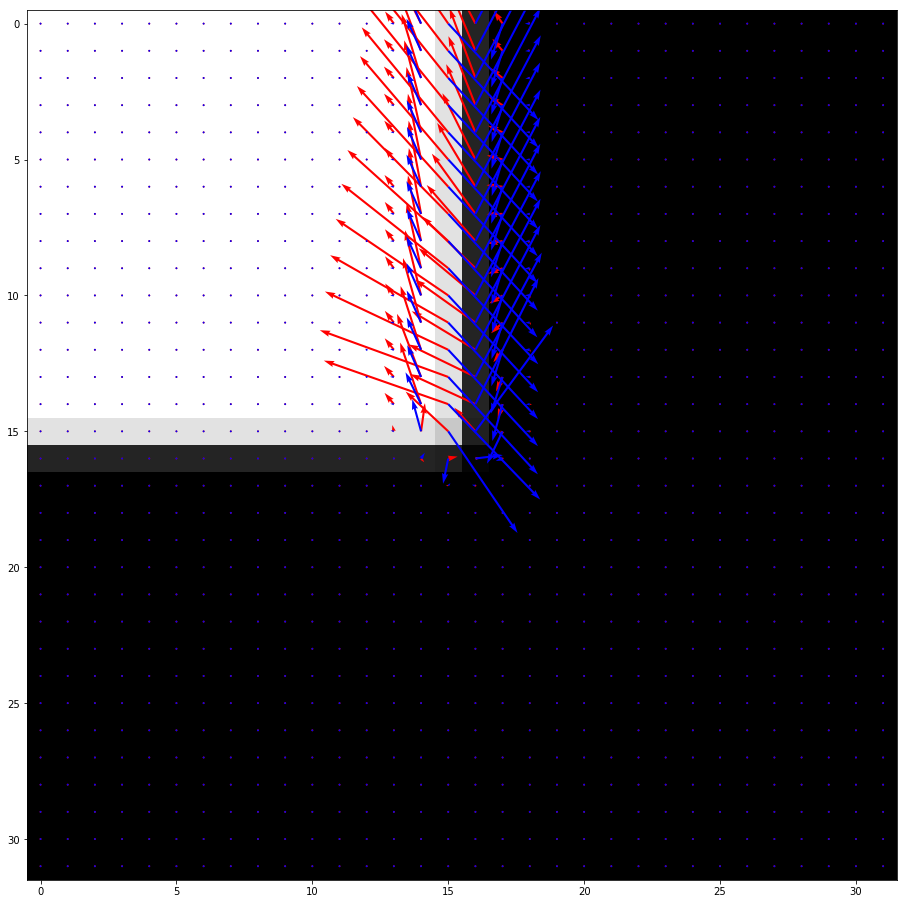

In [19]:
for level in range(0,max_level):
    U, V = np.meshgrid(range(0, imgslp2[level].shape[1]), range(0, imgslp2[level].shape[0]))
    u3 = (np.random.rand(imgslp2[level].shape[1],1)*(np.random.rand(imgslp2[level].shape[1],1)-0.5) + 1j*2*(np.random.rand(imgslp2[level].shape[1],1)-0.5))#
    u3[:] = 0 + 1j
    #l1 = (dtcwt.sampling.sample_highpass(
    #            np.tile(dtcwtpyramid.highpasses[level][:,0,0].reshape(dtcwtpyramid.highpasses[level][:,0,0].shape[0], 1, 1), [1,2,6]), 
    #            U[:,[0,0]]+0.5, V[:,[0,0]] + np.sin(15*np.pi/180), method='lanczos', sbs=[0])[:,0,:])

    for r in range(0, imgslp2[level].shape[0]):

        # Normalise the magnitude of the SLP2 value to stop it running away and becoming huge
        wdelta = (imgslp2[level][r,:,2]/np.abs(imgslp2[level][r,:,2])*np.exp(-1j*5*np.pi/12))**(slp2pyramid.rotratio[level,2]*1.035) # This should now contain the phase difference over one full pixel
        #print(np.angle(diffs[level][r,0,2]**0.5), np.angle(np.conj(wdelta[0])**0.5)) # This shows it does
        w.highpasses[level][r,:,2] = np.sqrt(np.abs(imgslp2[level][r,:,2]))*np.exp(1j*np.angle(np.multiply(u3.flatten(), np.conj(wdelta)**0.5)))
        l3 = np.multiply(u3.flatten(), np.conj(wdelta)).T
        if np.any(np.isnan(l3.flatten())):
            print(c)
            raise ValueError('Nans detected')

        # The values to be interpolated are shifted further from the axis by a constant amount
        u3 = np.interp(np.arange(0,imgslp2[level].shape[1])-0.5 + 1/1.035*np.sin(15*np.pi/180), \
                       np.arange(0,imgslp2[level].shape[1])-0.5, l3.flatten()*np.exp(1j*-3*np.pi/2.15*1/1.035*np.sin(15*np.pi/180)))


imshow(misc.imresize(img, 2**-(level+1)), cmap='gray')
#xlim([-1,10])
#ylim([10,-1])
quiver(U, V, np.real(w.highpasses[level][:,:,2]), np.imag(w.highpasses[level][:,:,2]), color='r', scale=20)
quiver(U, V, np.real(dtcwtpyramid.highpasses[level][:,:,2]), np.imag(dtcwtpyramid.highpasses[level][:,:,2]), color='b', scale=20)

16


(-3.14, 3.14)

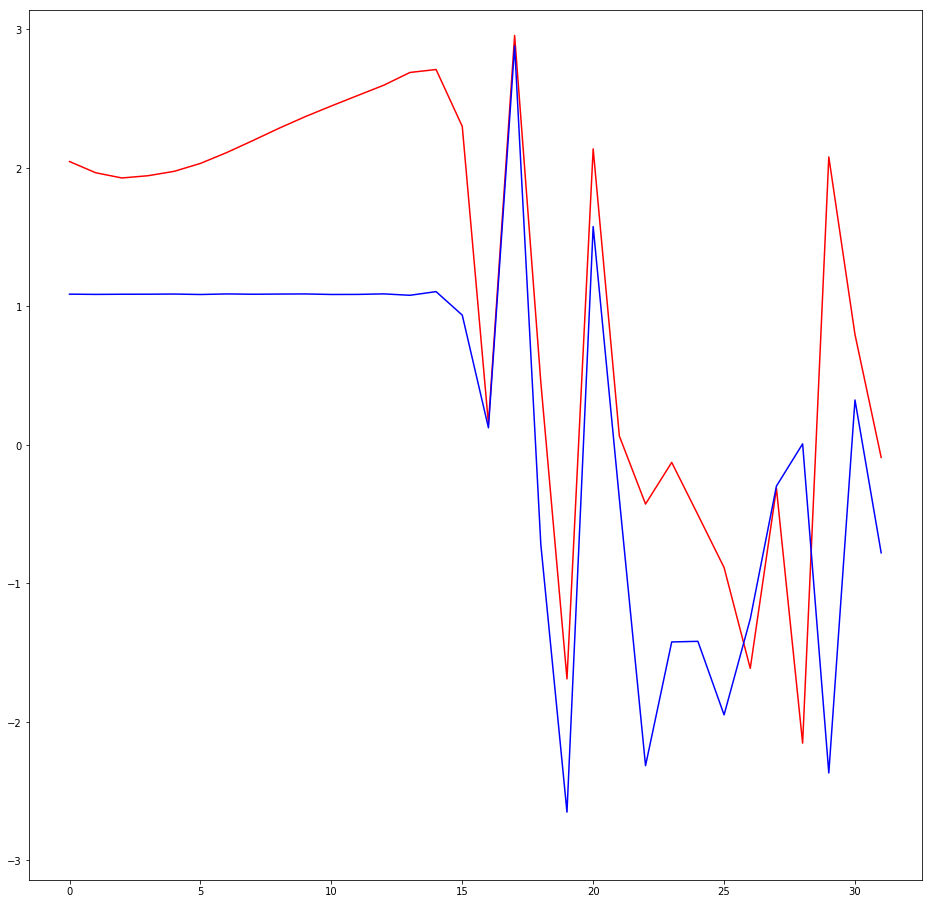

In [13]:
print(int(imgslp2[level].shape[1]/2))
plot(np.angle(w.highpasses[level][:,int(imgslp2[level].shape[1]/2),2]), color='r')
plot(np.angle(dtcwtpyramid.highpasses[level][:,int(imgslp2[level].shape[1]/2),2]), color='b')
ylim([-3.14,3.14])

# Subband 4

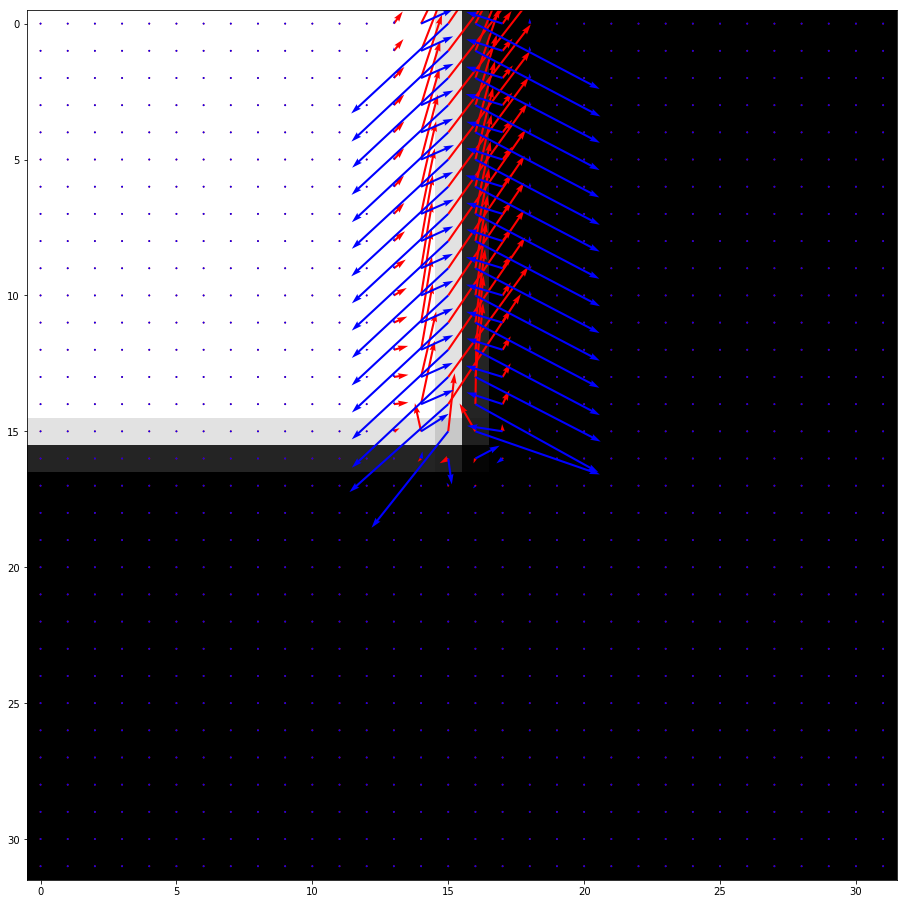

In [14]:
for level in range(0,max_level):
    U, V = np.meshgrid(range(0, imgslp2[level].shape[1]), range(0, imgslp2[level].shape[0]))
    # Initialise the first coefficient phases and magnitudes randomly
    u4 = (np.random.rand(imgslp2[level].shape[1],1)*(np.random.rand(imgslp2[level].shape[1],1)-0.5) + 1j*2*(np.random.rand(imgslp2[level].shape[1],1)-0.5))
    u4[:] = 0 + 1j
    # Initialise by interpolating the true values
    #u4 = (dtcwt.sampling.sample_highpass(
    #            np.tile(dtcwtpyramid.highpasses[level][0,:,3].reshape(1, dtcwtpyramid.highpasses[level].shape[1], 1), [2,1,6]), 
    #            U[0,:] - np.sin(15*np.pi/180), V[0,:]-0.5, method='bilinear', sbs=[3])[0,:,0])

    for r in range(0, imgslp2[level].shape[0]):

        # Normalise the magnitude of the SLP2 value to stop it running away and becoming huge
        wdelta = (imgslp2[level][r,:,3]/np.abs(imgslp2[level][r,:,3])*np.exp(-1j*7*np.pi/12))**(slp2pyramid.rotratio[level,3]*1.035) # This should now contain the phase difference over one full pixel
        #print(np.angle(diffs[level][r,0,3]**0.5), np.angle(wdelta[0]**0.5)) # This shows it does
        w.highpasses[level][r,:,3] = np.sqrt(np.abs(imgslp2[level][r,:,3]))*np.exp(1j*np.angle(np.multiply(u4.flatten(), np.conj(wdelta)**0.5)))
        l4 = np.multiply(u4.flatten(), np.conj(wdelta)).T
        if np.any(np.isnan(l4.flatten())):
            print(c)
            raise ValueError('Nans detected')

        # The values to be interpolated are shifted nearer to the axis by a constant amount
        u4 = np.interp(np.arange(0,imgslp2[level].shape[1])-0.5 - 1/1.035*np.sin(15*np.pi/180), \
                       np.arange(0,imgslp2[level].shape[1])-0.5, l4.flatten()*np.exp(1j*-3*np.pi/2.15*-1/1.035*np.sin(15*np.pi/180)))

imshow(misc.imresize(img, 2**-(level+1)), cmap='gray')
#xlim([-1,10])
#ylim([10,-1])
quiver(U, V, np.real(w.highpasses[level][:,:,3]), np.imag(w.highpasses[level][:,:,3]), color='r', scale=20)
quiver(U, V, np.real(dtcwtpyramid.highpasses[level][:,:,3]), np.imag(dtcwtpyramid.highpasses[level][:,:,3]), color='b', scale=20)

(-3.14, 3.14)

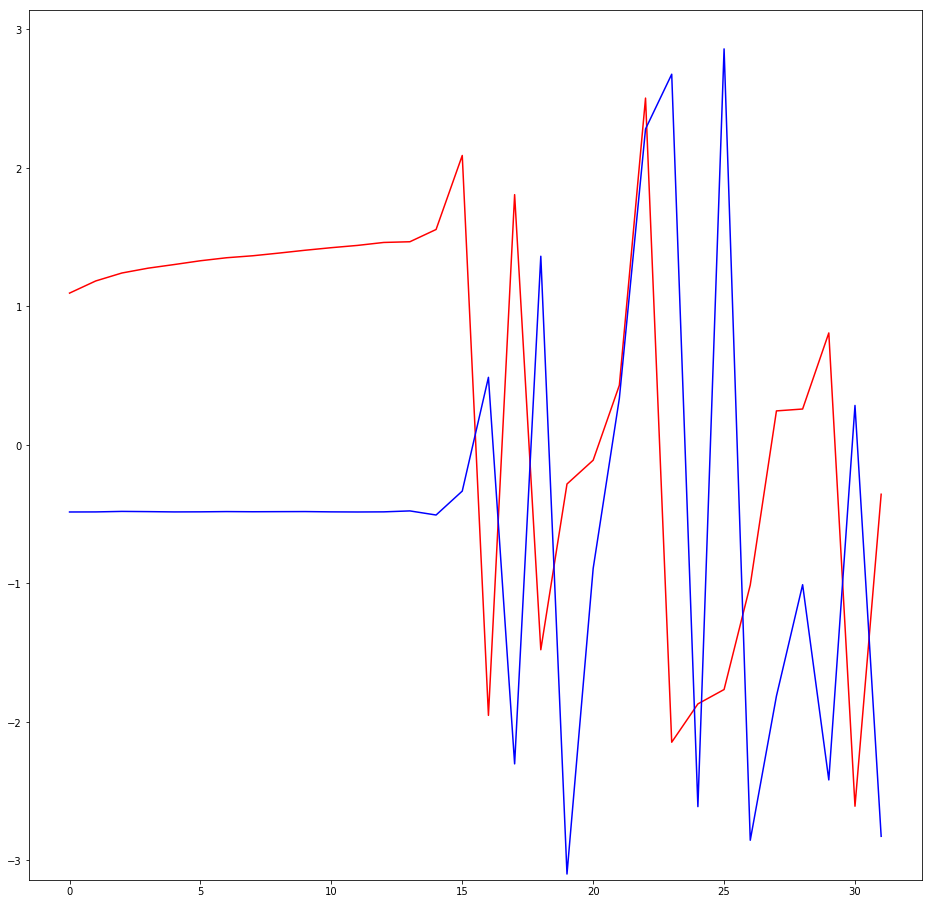

In [15]:
plot(np.angle(w.highpasses[level][:,int(imgslp2[level].shape[1]/2),3]), color='r')
plot(np.angle(dtcwtpyramid.highpasses[level][:,int(imgslp2[level].shape[1]/2),3]), color='b')
ylim([-3.14,3.14])

[ 0.02066066]


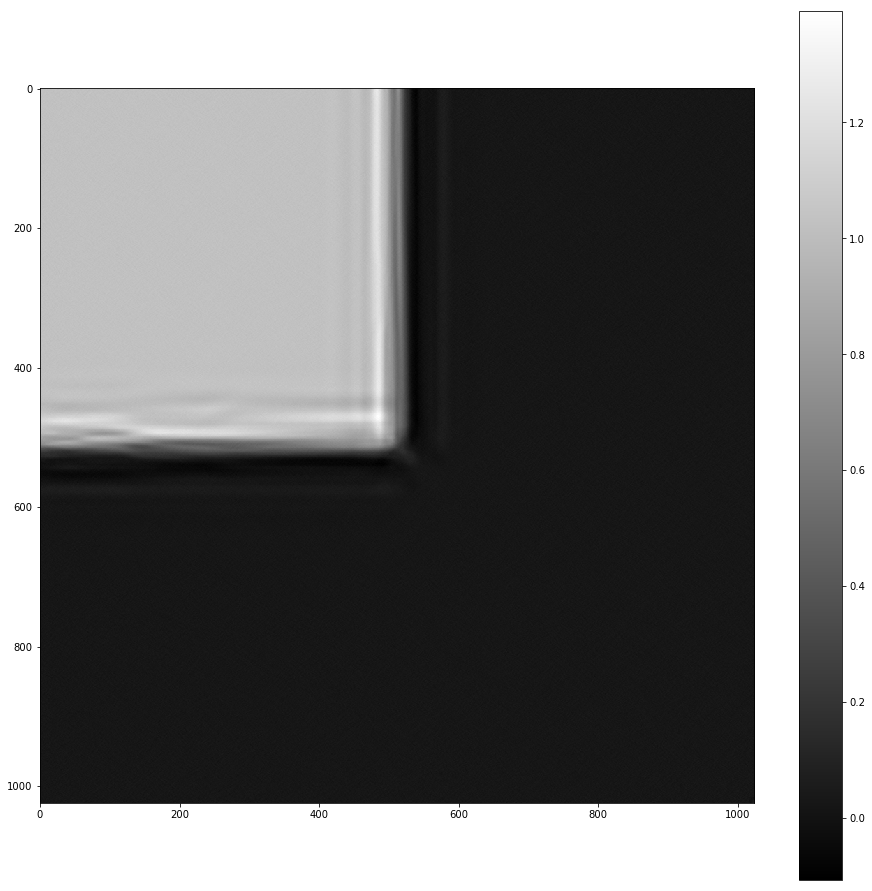

In [21]:
gm = np.ones([6,5])
#gm[:,[2,4]] = 0
#gm = np.ones([6, 6])
imshow(transform.inverse(dtcwtpyramid, gain_mask=gm)-transform.inverse(w, gain_mask=gm), cmap='gray')
#w.lowpass[:,:] = 0
imshow(transform.inverse(w, gain_mask=gm), cmap='gray')
colorbar()
print(np.mean(np.abs(transform.inverse(dtcwtpyramid)-transform.inverse(w))).flatten())

In [17]:
0.5/np.cos(15*np.pi/180)

0.51763809020504148